In [256]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import random
from functools import partial
import networkx as nx
import re
# penny
import pennylane as qml
from pennylane.transforms import *
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy
# self-developed
from transpilation_util import summary_penny, extract_info_from_qnode
from penny_to_graph_2 import Penny_to_Graph


In [2]:
[ds] = qml.data.load("ketgpt")

In [160]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

               0
num_qubit     13
num_gate     205
num_1q_gate  116
num_2q_gate   25
unitary       64
depth         72
None


In [161]:
print(ds.circuits[0][0])
type(ds.circuits[0][0])

H(0)


pennylane.ops.qubit.non_parametric_ops.Hadamard

Matplotlib is building the font cache; this may take a moment.


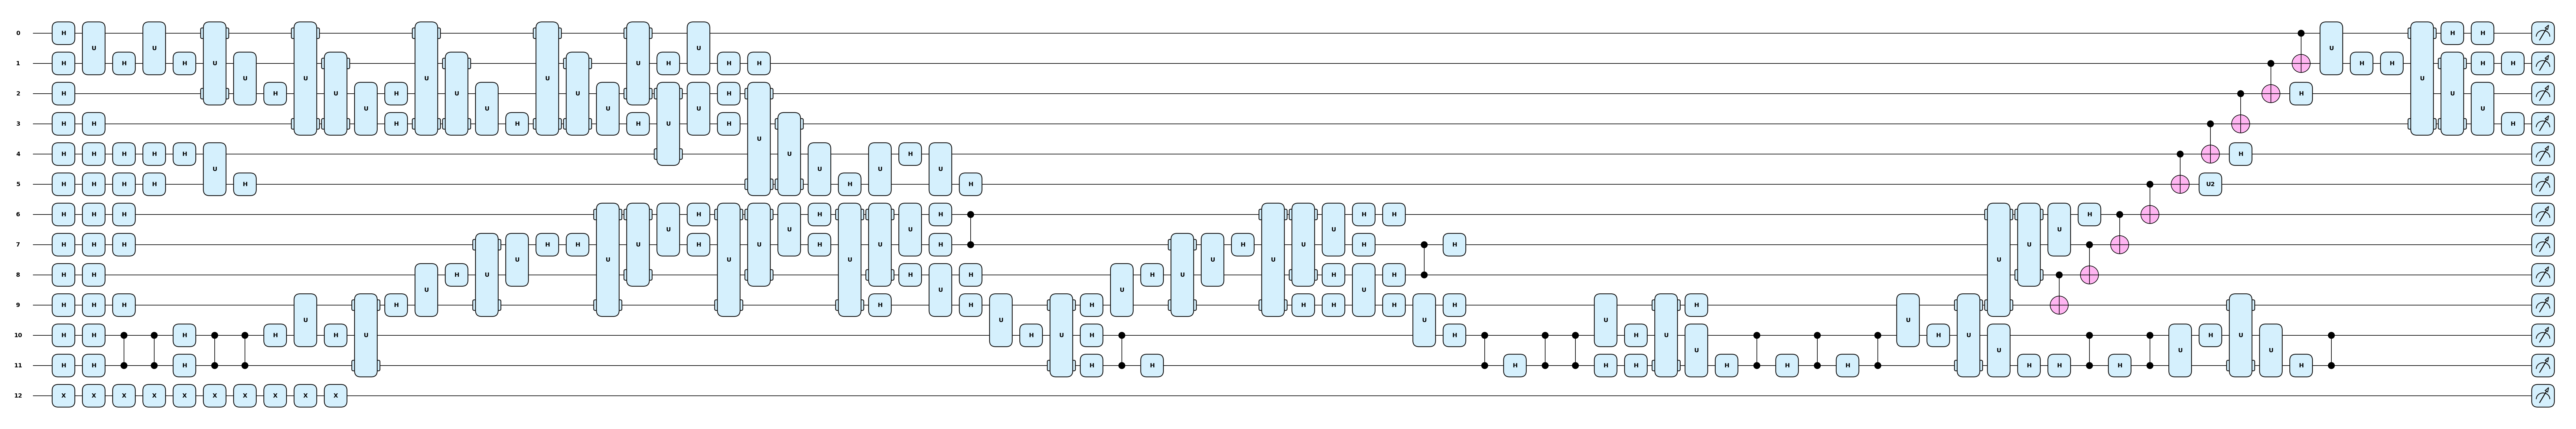

In [162]:
fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

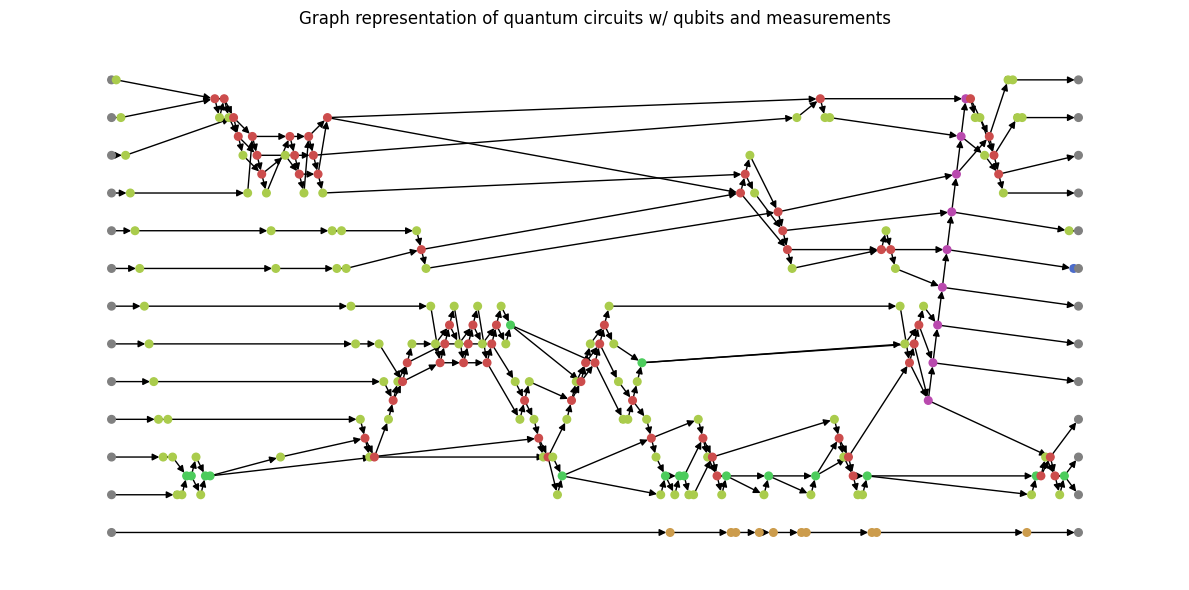

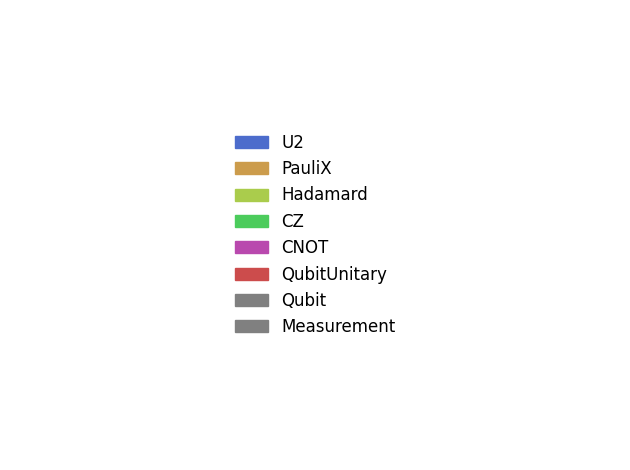

In [5]:
my_pg = Penny_to_Graph(circuit)
G_aug = my_pg.G_aug
G = my_pg.G
# my_pg.show_graph()
my_pg.show_aug_graph()
my_pg.show_legend()

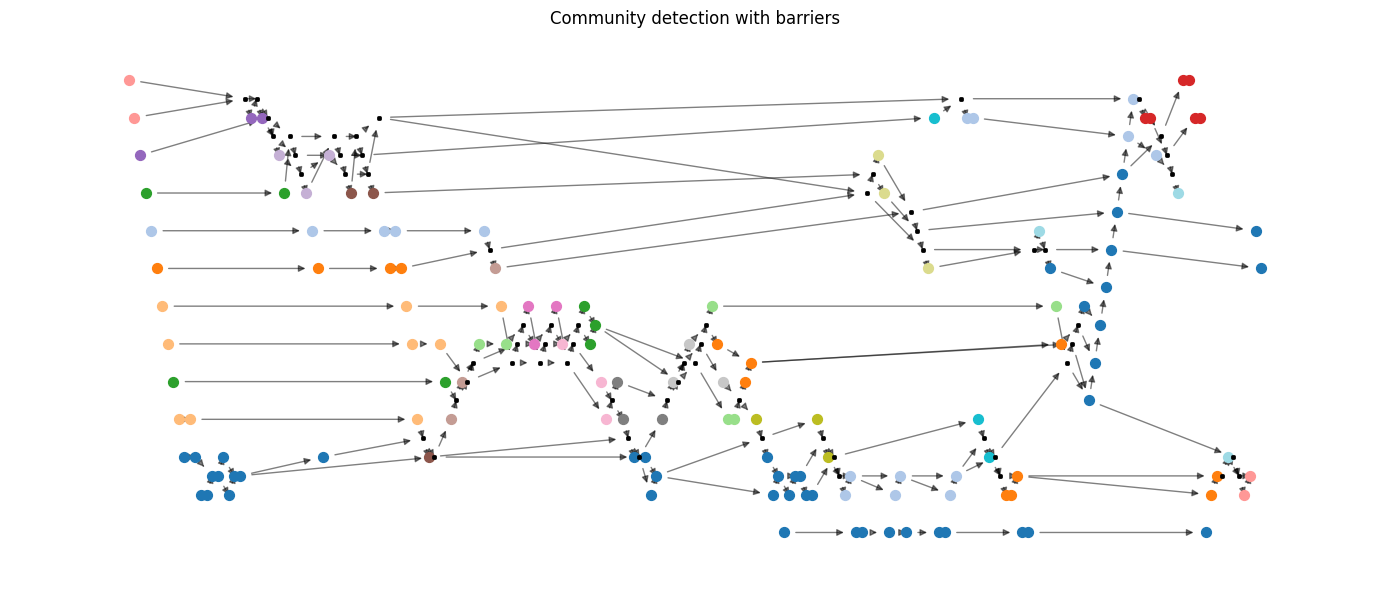

In [6]:
node_arr = list(G.nodes())

# Define barrier nodes
barrier_nodes = [node for node in node_arr if node.startswith('QubitUnitary')]

# Create a copy for community detection
G_community = G.copy()
G_community.remove_nodes_from(barrier_nodes)

# Detect communities
communities = nx.community.greedy_modularity_communities(G_community)

# Convert to list of sets
community_list = [set(c) for c in communities]

# Assign colors to communities
color_map = {}
num_communities = len(community_list)
cmap = plt.get_cmap('tab20', num_communities + 1)  # +1 for barrier color

# Assign community colors
for i, community in enumerate(community_list):
    for node in community:
        color_map[node] = cmap(i)

# Assign same color to all barrier nodes (last color in colormap)
barrier_color = 'black'
for node in barrier_nodes:
    color_map[node] = barrier_color

# Draw the graph
# pos = nx.spring_layout(G, seed=42)
pos = my_pg.pos

plt.figure(figsize=(14, 6))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw nodes by community
for i, community in enumerate(community_list):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(community),
        node_color=[cmap(i)],
        label=f"Community {i+1}",
        node_size=50,
        # edgecolors='black'
    )

# Draw barrier nodes with same color and thicker border
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=barrier_nodes,
    node_color='black',
    label="Barrier Nodes",
    node_size=1,
    linewidths=2,
    node_shape='s'  # square shape for visual distinction
)

plt.title("Community detection with barriers")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
node_arr = list(G.nodes())

# Define barrier nodes
barrier_nodes = [node for node in node_arr if node.startswith('QubitUnitary')]

# Create a copy for community detection
G_community = G.copy()
G_community.remove_nodes_from(barrier_nodes)

# Detect communities
communities = nx.community.greedy_modularity_communities(G_community)

##### sort the comm

# Step 2: Create a mapping from node to community index
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Step 3: Extract numeric index from node names
def extract_index(name):
    match = re.search(r'_(\d+)$', name)
    return int(match.group(1)) if match else None

# Step 4: Sort nodes by numeric index
sorted_nodes = sorted(G.nodes(), key=extract_index)

# Step 5: Get community index for each node in sorted order
community_labels = [node_to_community[node] for node in sorted_nodes]

#####

# Convert to list of sets
community_list = [set(c) for c in communities]

# Assign colors to communities
color_map = {}
num_communities = len(community_list)
cmap = plt.get_cmap('tab20', num_communities + 1)  # +1 for barrier color

# Assign community colors
for i, community in enumerate(community_list):
    for node in community:
        color_map[node] = cmap(i)

# Assign same color to all barrier nodes (last color in colormap)
barrier_color = 'black'
for node in barrier_nodes:
    color_map[node] = barrier_color

# Draw the graph
# pos = nx.spring_layout(G, seed=42)
pos = my_pg.pos

plt.figure(figsize=(14, 6))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw nodes by community
for i, community in enumerate(community_list):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(community),
        node_color=[cmap(i)],
        label=f"Community {i+1}",
        node_size=50,
        # edgecolors='black'
    )

# Draw barrier nodes with same color and thicker border
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=barrier_nodes,
    node_color='black',
    label="Barrier Nodes",
    node_size=1,
    linewidths=2,
    node_shape='s'  # square shape for visual distinction
)

plt.title("Community detection with barriers")
plt.axis('off')
plt.tight_layout()
plt.show()

KeyError: 'QubitUnitary_21'

In [ ]:
# Assign community index to each node in G
for i, community in enumerate(communities):
    for node in community:
        G.nodes[node]['community'] = i

In [149]:
import networkx as nx
import re

# Step 0: Assume G is your graph
# Example: G = nx.Graph() and G.add_edges_from([...])

# Step 1: Identify barrier nodes
barriers = [node for node in G.nodes if 'QubitUnitary' in node]

# Step 2: Create subgraph excluding barriers
G_sub = G.subgraph([node for node in G.nodes if node not in barriers])

# Step 3: Apply community detection
communities = list(nx.community.greedy_modularity_communities(G_sub))

# Step 4: Add each barrier as its own singleton community
for barrier in barriers:
    communities.append({barrier})

# Step 5: Create a mapping from node to original community index
node_to_original_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_original_community[node] = i

# Step 6: Extract numeric index from node names
def extract_index(name):
    match = re.search(r'_(\d+)$', name)
    return int(match.group(1)) if match else None

# Step 7: Sort nodes by numeric index
sorted_nodes = sorted(G.nodes(), key=extract_index)

# Step 8: Reindex communities based on first appearance in sorted node list
original_to_new_index = {}
new_index = 0
node_to_reindexed_community = {}

for node in sorted_nodes:
    original = node_to_original_community[node]
    if original not in original_to_new_index:
        original_to_new_index[original] = new_index
        new_index += 1
    node_to_reindexed_community[node] = original_to_new_index[original]

# Step 9: Assign reindexed community index to each node in G
for node in G.nodes:
    G.nodes[node]['community'] = node_to_reindexed_community[node]

# Optional: Print results
for node in sorted_nodes:
    print(f"{node}: Community {G.nodes[node]['community']}")

Hadamard_0: Community 0
Hadamard_1: Community 1
Hadamard_2: Community 2
Hadamard_3: Community 3
Hadamard_4: Community 4
Hadamard_5: Community 5
Hadamard_6: Community 6
Hadamard_7: Community 7
Hadamard_8: Community 8
Hadamard_9: Community 9
Hadamard_10: Community 10
Hadamard_11: Community 9
Hadamard_12: Community 10
Hadamard_13: Community 10
Hadamard_14: Community 10
CZ_15: Community 10
CZ_16: Community 10
Hadamard_17: Community 10
Hadamard_18: Community 10
CZ_19: Community 10
CZ_20: Community 10
QubitUnitary_21: Community 11
Hadamard_22: Community 12
QubitUnitary_23: Community 13
Hadamard_24: Community 14
QubitUnitary_25: Community 15
QubitUnitary_26: Community 16
Hadamard_27: Community 17
Hadamard_28: Community 3
QubitUnitary_29: Community 18
QubitUnitary_30: Community 19
QubitUnitary_31: Community 20
Hadamard_32: Community 21
Hadamard_33: Community 4
Hadamard_34: Community 5
Hadamard_35: Community 10
Hadamard_36: Community 22
QubitUnitary_37: Community 23
QubitUnitary_38: Community 2

In [150]:
G.nodes['Hadamard_0']

{'type': 'gate',
 'label': 'Hadamard',
 'params': [],
 'wires': [0],
 'community': 0}

In [151]:
# subcircut synthesis summary

def wire_range(gate_list):
    wires = []
    for gate in gate_list:
        if hasattr(gate, 'wires'):
            wires.extend(gate.wires)
        elif hasattr(gate, 'wire'):
            wires.append(gate.wire)
        elif isinstance(gate, tuple) or isinstance(gate, list):
            # fallback for custom gate representations
            for item in gate:
                if hasattr(item, 'wires'):
                    wires.extend(item.wires)
                elif hasattr(item, 'wire'):
                    wires.append(item.wire)
        elif hasattr(gate, '__str__'):
            # fallback for string-like gates like H(0)
            match = re.findall(r'\((\d+)\)', str(gate))
            wires.extend([int(m) for m in match])
    return [min(wires), max(wires)]

def calculate_effective_u(subcircuit):
    """takes a subcircuit as input and returns an effective unitary"""
    [w_min, w_max] = wire_range(subcircuit)

    # if w_min == w_max: # for 1q gates, return them as they are
    #     return np.array(subcircuit), np.array([w_max])

    wires = np.arange(w_min, w_max+1,1)
    num_eq = w_max - w_min + 1
    initial_matrix = np.diag(np.ones(np.power(2,num_eq)))

    # effective unitary
    dev = qml.device('default.qubit', wires=wires)
    @qml.qnode(dev)
    def internal_circuit(idx):
        qml.StatePrep(initial_matrix[idx], wires=wires)
        for j in subcircuit:
            qml.apply(j)
        return qml.state()
    
    effective_u = []
    for idx in range(np.power(2,num_eq)):
        effective_u.append(internal_circuit(idx))
    effective_u = np.stack(effective_u, axis=1)
    
    return effective_u, wires

def subcircuit_syntehsis(G, ds, communities, seed=0):
    num_community = len(communities)
    # idx
    subcircuit_idx_arr = []
    for i in range(num_community):
        temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
        temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
        subcircuit_idx_arr.append(temp_com_label)

    # gate list
    subcircuit_gate_arr = []
    for i in range(num_community):
        subcircuit_gate_arr.append([ds.circuits[seed][j] for j in subcircuit_idx_arr[i]])

    u_arr = []
    wire_arr = []
    for i in range(num_community):
        u_temp, w_temp = calculate_effective_u(subcircuit_gate_arr[i])
        u_arr.append(u_temp)
        wire_arr.append(w_temp)

    effective_u_dic = {}
    effective_u_dic['u'] = u_arr
    effective_u_dic['wires'] = wire_arr

    return effective_u_dic

In [152]:
print(subcircuit_syntehsis(G, ds, communities, seed=0)['u'][0])
print(subcircuit_syntehsis(G, ds, communities, seed=0)['wires'][0])

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
[0]


In [153]:
print(subcircuit_syntehsis(G, ds, communities, seed=0)['u'][10:20])
print(subcircuit_syntehsis(G, ds, communities, seed=0)['wires'][10:20])

[array([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
         0.70710678+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
        -0.70710678+0.j]]), array([[1.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 1.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 1.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        6.123234e-17-1.j]]), array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]]), array([[1.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 1.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.00000

In [177]:
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed=0)
num_gate = len(effective_u_dic['u'])

dev = qml.device('default.qubit')

# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(dev)
def decompose_combined_u():
    for i in range(num_gate):
        qml.QubitUnitary(effective_u_dic['u'][i], wires=effective_u_dic['wires'][i])
    return qml.state()

print(summary_penny(decompose_combined_u))

               0
num_qubit     13
num_gate     125
num_1q_gate   52
num_2q_gate    0
unitary      125
depth         56
None


In [ ]:
def is_identity(gate):
    return np.allclose(gate, np.eye(gate.shape[0]))

is_identity(effective_u_dic['u'][3])

True

In [241]:
def is_hadamard(gate):
    h = effective_u_dic['u'][1].real
    return np.allclose(gate, h)

def is_x(gate):
    x = np.array([[0,1], [1,0]])
    return np.allclose(gate, x)

is_hadamard(effective_u_dic['u'][2])

True

In [237]:
effective_u_dic['u'][1].shape[0]

2

In [242]:
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed=0)
num_gate = len(effective_u_dic['u'])

dev = qml.device('default.qubit')

# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})

@qml.qnode(dev)
def decompose_combined_u():
    for i in range(num_gate):
        params = effective_u_dic['u'][i]
        dim = params.shape[0]
        wires = effective_u_dic['wires'][i]
        if is_identity(params):
            continue
        if dim == 2:
            if is_hadamard(params):
                qml.Hadamard(wires[0])
            if is_x(params):
                qml.PauliX(wires[0])
        else:
            qml.QubitUnitary(params, wires=wires)
    return qml.state()

print(summary_penny(decompose_combined_u))

               0
num_qubit     12
num_gate     115
num_1q_gate   42
num_2q_gate    0
unitary       73
depth         55
None


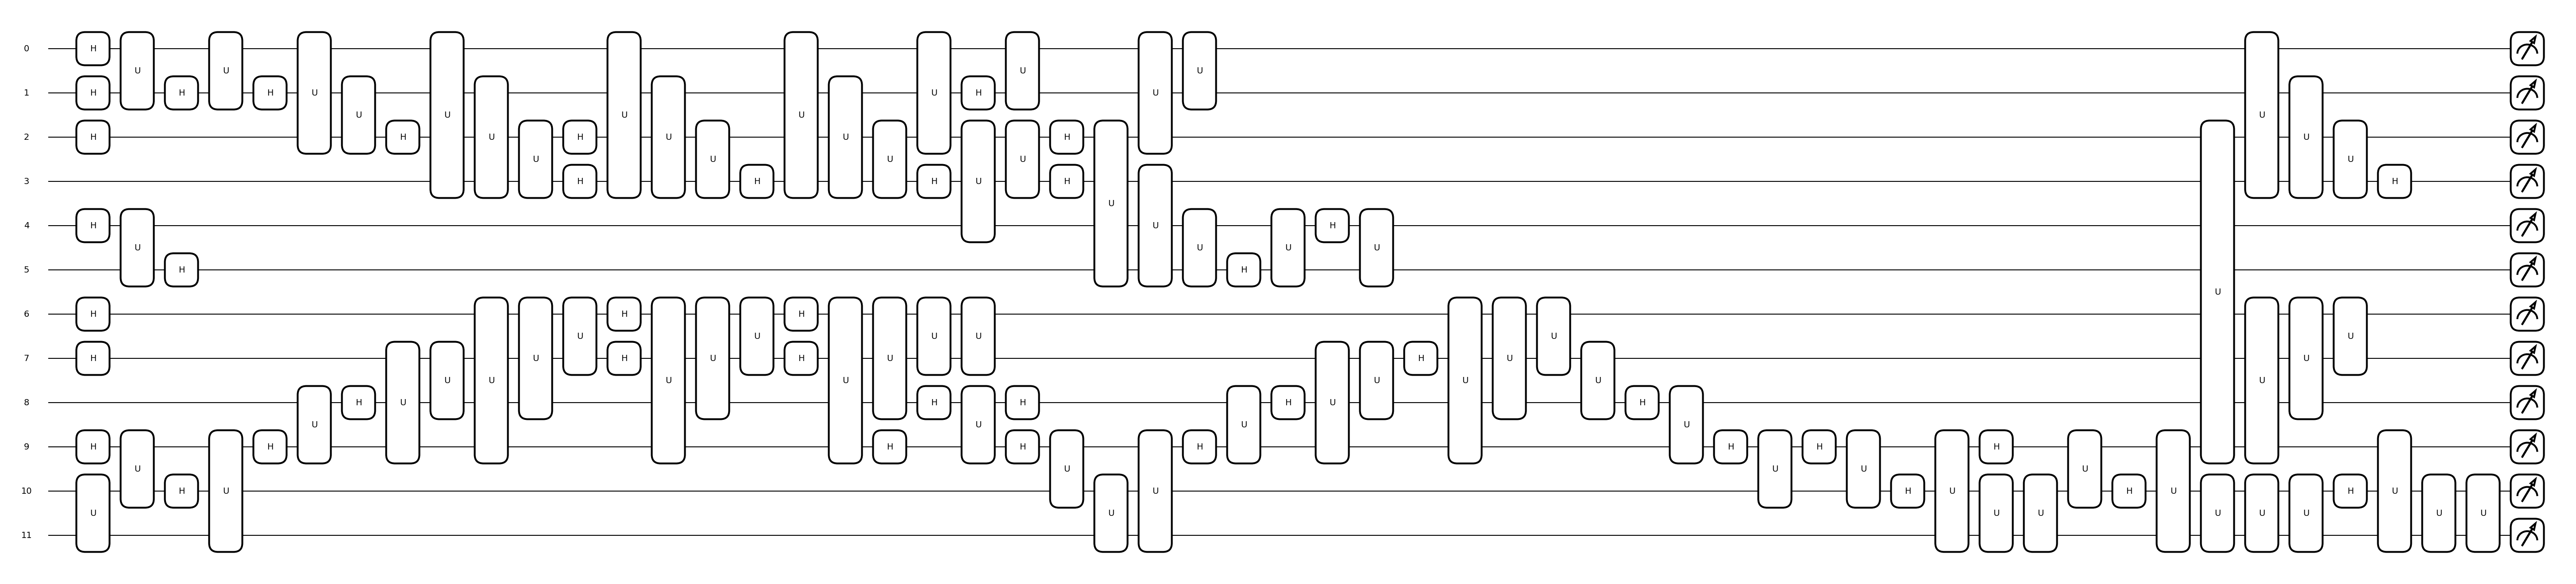

In [243]:
qml.draw_mpl(decompose_combined_u)()
plt.show()

In [277]:
circuit_level_1 = extract_info_from_qnode(decompose_combined_u)

# Extract all entries with name 'QubitUnitary'
qubit_unitaries = [gate for gate in circuit_level_1 if gate['name'] == 'QubitUnitary']

test = qubit_unitaries[0]
dim = np.power(2,len(test['wires']))
pd.DataFrame(np.array(test['params']).reshape(dim,dim))


,0,1,2,3
0,0.707107+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,0.707107+0.000000j,-0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j
2,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.707107+0.000000j
3,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,-0.707107+0.000000j


In [335]:
circuit_level_1

[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []},
 {'name': 'Hadamard', 'wires': [4], 'params': []},
 {'name': 'Hadamard', 'wires': [6], 'params': []},
 {'name': 'Hadamard', 'wires': [7], 'params': []},
 {'name': 'Hadamard', 'wires': [9], 'params': []},
 {'name': 'QubitUnitary',
  'wires': [10, 11],
  'params': [[[(0.7071067811865471+0j), (0.7071067811865471+0j), 0j, 0j],
    [(0.7071067811865471+0j), (-0.7071067811865471+0j), 0j, 0j],
    [0j, 0j, (0.7071067811865471+0j), (0.7071067811865471+0j)],
    [0j, 0j, (0.7071067811865471+0j), (-0.7071067811865471+0j)]]]},
 {'name': 'QubitUnitary',
  'wires': [0, 1],
  'params': [[[(1+0j), 0j, 0j, 0j],
    [0j, (1+0j), 0j, 0j],
    [0j, 0j, (1+0j), 0j],
    [0j, 0j, 0j, (6.123233995736766e-17-1j)]]]},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'QubitUnitary',
  'wires': [0, 1],
  'params': [[[(1+0j), 0j, 0j, 0j],
    [0j, (1

In [342]:
indices = [i for i, item in enumerate(qubit_unitaries) if len(item.get('wires', [])) == 8]

print(indices[0])

test = qubit_unitaries[indices[0]]
dim = np.power(2,len(test['wires']))
pd.DataFrame(np.array(test['params']).reshape(dim,dim))

61


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.25+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,-0.25+0.00j,0.25+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,0.00+0.00j,0.25+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,-0.25+0.00j,0.00+0.00j,0.00+0.00j,0.25+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.25+0.00j,-0.25+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.00+0.00j,0.00+0.00j,0.25+0.00j,0.00+0.00j,0.00+0.00j,-0.25+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,-0.25+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.25+0.00j,0.25+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
252,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
253,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
254,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,0.00+0.00j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


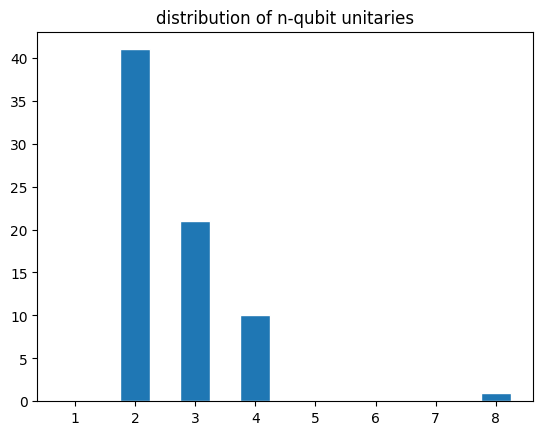

In [334]:
u_dim = []
for i in qubit_unitaries:
    u_dim.append(len(i['wires']))

plt.hist(u_dim, edgecolor='white',bins=np.arange(1,10,1), range=np.arange(1,10,1), align='left', rwidth=0.5)
plt.title('distribution of n-qubit unitaries')
plt.show()

In [ ]:
dev = qml.device('default.qubit')
@compile
@partial(decompose, gate_set={qml.CNOT, qml.Hadamard, qml.PauliX, qml.PauliY, qml.PauliZ, qml.RX, qml.RY, qml.RZ}) # new sets
@qml.qnode(dev)
def decompose_combined_u():
    for i in range(num_gate):
        params = effective_u_dic['u'][i]
        dim = params.shape[0]
        wires = effective_u_dic['wires'][i]
        if is_identity(params):
            continue
        if dim == 2:
            if is_hadamard(params):
                qml.Hadamard(wires[0])
            if is_x(params):
                qml.PauliX(wires[0])
        else:
            qml.QubitUnitary(params, wires=wires)
    return qml.state()

print(summary_penny(decompose_combined_u))

In [285]:
dev = qml.device('default.qubit')
@partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[0][:10]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

              0
num_qubit    10
num_gate     30
num_1q_gate  30
num_2q_gate   0
unitary       0
depth         3
None


In [293]:
dev = qml.device('default.qubit')
@compile
@partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[0][:30]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

               0
num_qubit     12
num_gate     134
num_1q_gate  119
num_2q_gate   15
unitary        0
depth         50
None


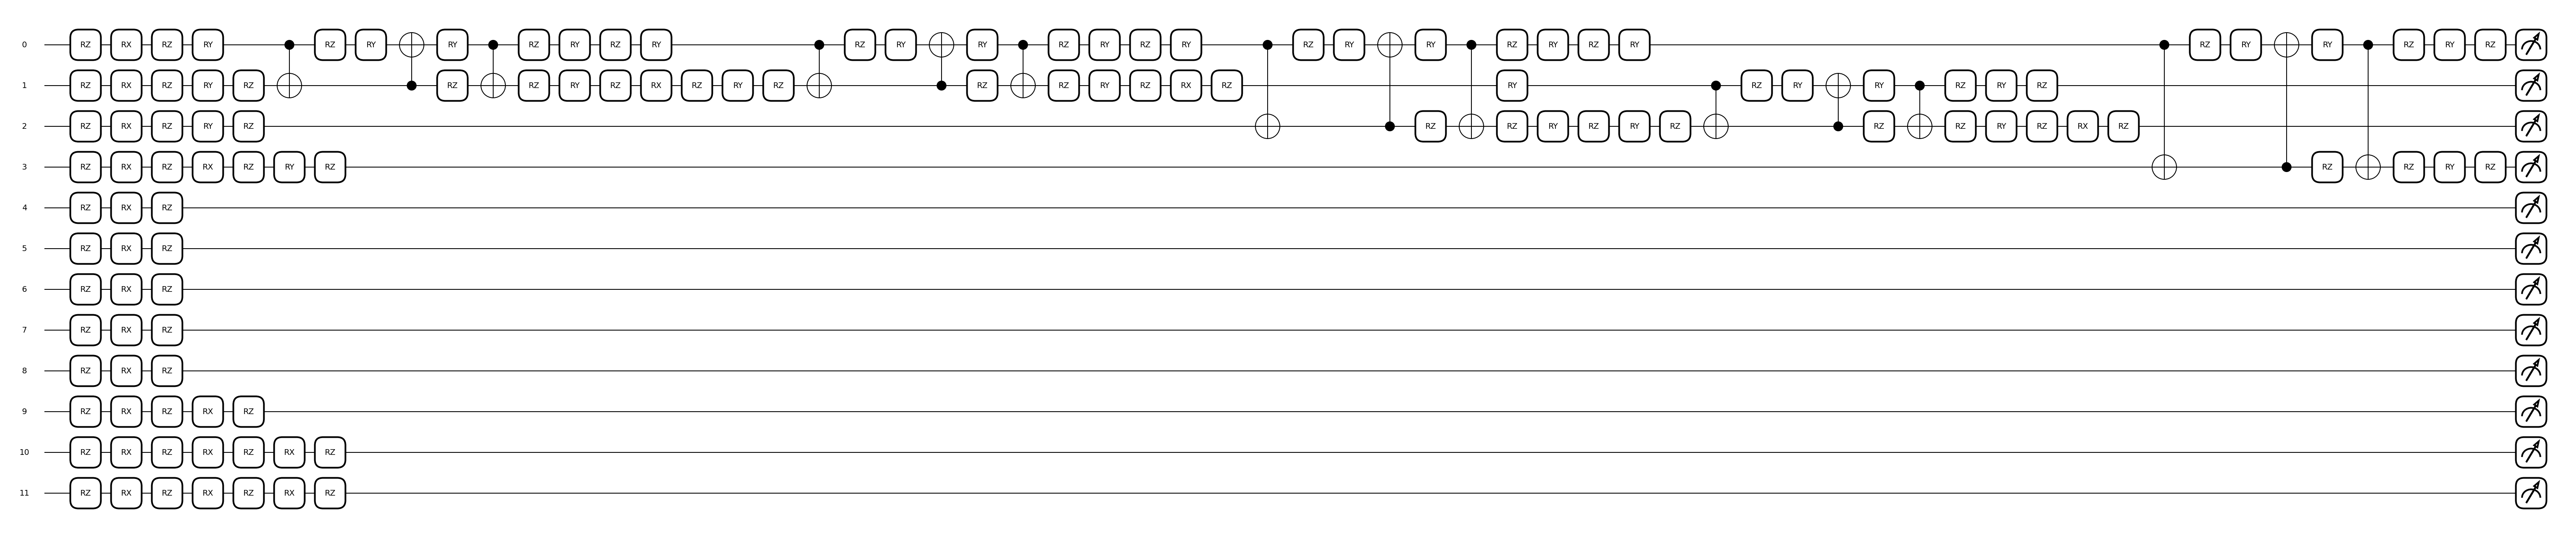

In [294]:
qml.draw_mpl(circuit)()
plt.show()

In [316]:
dev = qml.device('default.qubit')
# @partial(decompose, gate_set={qml.CZ,qml.RZ,qml.SX, qml.PauliX})
@partial(decompose, gate_set={qml.CZ,qml.RZ, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for i in range(3):
        qml.Hadamard(i)
    return qml.state()

print(circuit())
print(summary_penny(circuit))

[0.+0.35355339j 0.+0.35355339j 0.+0.35355339j 0.+0.35355339j
 0.+0.35355339j 0.+0.35355339j 0.+0.35355339j 0.+0.35355339j]
             0
num_qubit    3
num_gate     9
num_1q_gate  9
num_2q_gate  0
unitary      0
depth        3
None


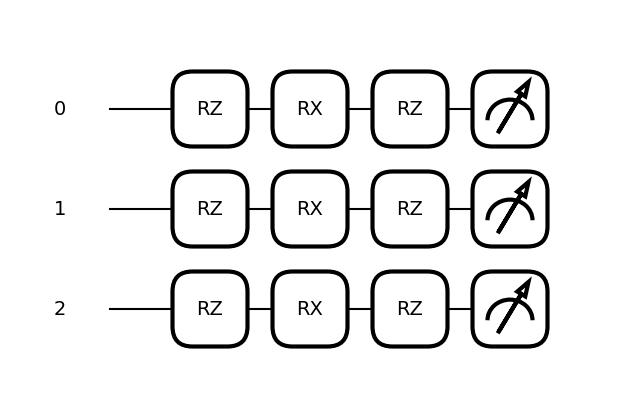

In [317]:
qml.draw_mpl(circuit)()
plt.show()

In [308]:
dev = qml.device('default.qubit')
# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for i in range(3):
        qml.RY(np.pi/2, wires=i)
    return qml.state()

print(circuit())
print(summary_penny(circuit))

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
             0
num_qubit    3
num_gate     3
num_1q_gate  3
num_2q_gate  0
unitary      0
depth        1
None


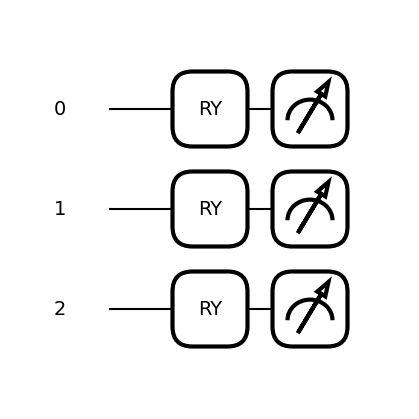

In [309]:
qml.draw_mpl(circuit)()
plt.show()

In [318]:
dev = qml.device('default.qubit')
# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for i in range(3):
        qml.SX(wires=i)
        qml.RZ(np.pi/2, wires=i)
        qml.SX(wires=i)
    return qml.state()

print(circuit())
print(summary_penny(circuit))

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
             0
num_qubit    3
num_gate     9
num_1q_gate  9
num_2q_gate  0
unitary      0
depth        3
None


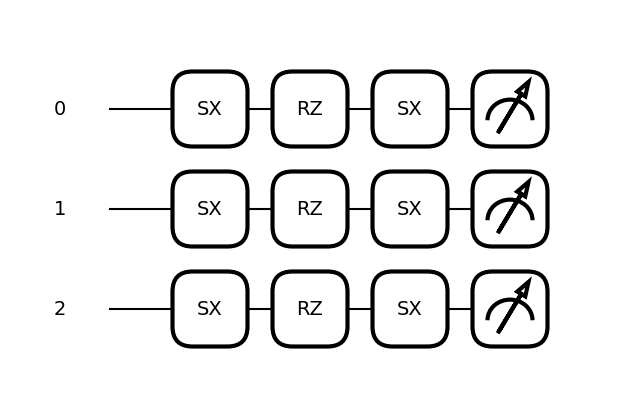

In [311]:
qml.draw_mpl(circuit)()
plt.show()